# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step -1: Imports

In [1]:
import numpy as np
import os
import pickle
import tensorflow as tf
import threading
import time
from PIL import Image as im
from PIL import ImageEnhance as ime

---
## Step 0: Load The Data

In [2]:
# Load pickled data
# TODO: Fill this in based on where you saved the training and testing data

training_file = '../data/traffic_signs/train.p'
testing_file = '../data/traffic_signs/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
assert X_train.shape[1:] == X_test.shape[1:], 'Train and test image shapes are not the same.'


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.hstack((y_train, y_test))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def get_sample_images(img, lab):
    l, indices = np.unique(lab, return_index=True)
    return img[indices]
    
def plot_images(images, images_to_show=10, img_per_row=10):
    assert images_to_show > 0
    assert img_per_row    > 0
    
    images_to_show = min(images_to_show, images.shape[0])
    rows           = int(np.ceil(float(images_to_show) / img_per_row))
    img_space      = np.full(image_shape, 255, dtype=images.dtype)
    col_space_w    = 5
    col_space      = np.full((image_shape[0], col_space_w, 3), 255, dtype=images.dtype)
    col_space_h    = 5
    row_len        = (image_shape[1] + col_space_w) * img_per_row - col_space_w
    row_space      = np.full((col_space_h, row_len, 3), 255, dtype=images.dtype)
    grid           = np.array([], dtype=images.dtype).reshape((0, row_len, 3))
    cur_img        = 0
    # This can be made more pythonic but it's fine for now.
    for row in range(rows):
        cur_row = np.array([], dtype=images.dtype).reshape((32,0,3))
        for col in range(img_per_row):
            if cur_img < images.shape[0]:
                cur_row = np.hstack((cur_row, images[cur_img]))
                cur_img += 1
            else:
                cur_row = np.hstack((cur_row, img_space))
            if col < img_per_row - 1:
                cur_row = np.hstack((cur_row, col_space))
        grid = np.vstack((grid, cur_row))
        if row < rows - 1:
            grid = np.vstack((grid, row_space))
    fsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = plt.figaspect(grid)
    plt.imshow(grid)
    plt.rcParams["figure.figsize"] = fsize

Some images from training set (1 image per class):

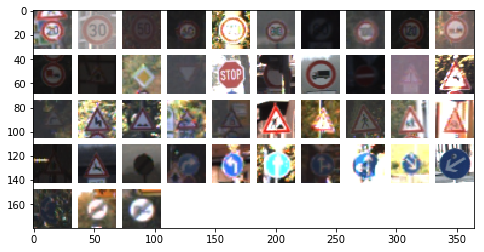

In [5]:
plot_images(get_sample_images(X_train, y_train), images_to_show=n_classes)

And some images from test set (1 image per class):

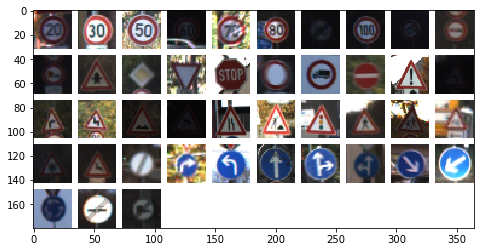

In [6]:
plot_images(get_sample_images(X_test, y_test), images_to_show=n_classes)

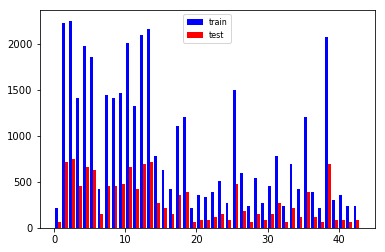

In [7]:
def plot_hist(lab_train, lab_test):
    fig, ax = plt.subplots()
    bins = range(0, n_classes + 1)
    n, dst_bins, patches = ax.hist([lab_train, lab_test], bins, histtype='bar', color=['blue', 'red'], label=['train', 'test'])
    ax.legend(prop={'size': 8})
    plt.show()

plot_hist(y_train, y_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def create_train_and_val_datasets(images, labels, val_fraction = 0.15):
    """
    Create:
        1. Balanced training dataset with oversampling.
        2. Validation dataset
    Returns a tuple of list of indices to images/labels for train/val sets.
    """
    assert images.shape[0] == labels.shape[0]
    l, counts = np.unique(labels, return_counts=True)
    max_idx   = np.argmax(counts)
    max_count = counts[max_idx]
    print('Class {} is the largest with {} samples.'.format(max_idx, max_count))
    val_counts      = np.ceil(val_fraction * counts).astype(counts.dtype)
    train_counts    = counts - val_counts
    train_img_idx   = np.array([], dtype=counts.dtype)
    val_img_idx     = np.array([], dtype=counts.dtype)
    cur_imgs        = np.zeros_like(counts)
    max_train_count = train_counts[max_idx]
    for i in range(images.shape[0]):
        lab_idx   = labels[i]
        if cur_imgs[lab_idx] < val_counts[lab_idx]:
            val_img_idx = np.append(val_img_idx, i)
            cur_imgs[lab_idx] += 1
        else:
            # Duplicate image as needed.
            for k in range(int(np.ceil(float(max_train_count) / train_counts[lab_idx]))):
                if cur_imgs[lab_idx] - val_counts[lab_idx] >= max_train_count:
                    break
                train_img_idx = np.append(train_img_idx, i)
                cur_imgs[lab_idx] += 1
    return train_img_idx, val_img_idx

X_train_idx, X_val_idx = create_train_and_val_datasets(X_train, y_train)
print('Training   set size: %d' % len(X_train_idx))
print('Validation set size: %d' % len(X_val_idx))


Class 2 is the largest with 2250 samples.
Training   set size: 82216
Validation set size: 5891


Train dataset after rebalancing:

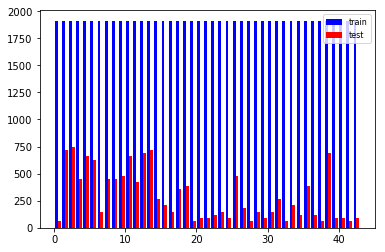

In [9]:
plot_hist(y_train[X_train_idx], y_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
At this moment, the only static pre-processing that was done is balancing the dataset with oversampling. Looking at histogram of class distribution, it is clear that some classes are under-represented. There are 2 common ways to solve the problem: oversampling and undersampling. As we don't have too many images in the training set, I chose to oversample the dataset. Oversampling has to be done carefully to make sure that it actually helps in improving generalization of the model rather than just bloating the dataset without helping generalization. In my neural nets I use dynamic data augmentation to improve generalization.

For dynamic (runtime) data augmentation I have created an input pipeline which randomly performs certain operations like scale, crop, rotate, change brightness, contrast and saturation of each image in a minibatch on every run. That is, it is almost guaranteed that the network will never see _exactly_ the same image during the training. 
See ```transform_batch_train``` code for more details. 
I have decided to use PIL library to implement the data pipeline. For large models and dataset, I would choose TensorFlow data pipeline where all image-related operations can be implemented using functions from ```tf.image``` and asynchronous reading can be done via ```QueueRunner``` and ```Coordinator``` but I have chosen not to do it here for the sake of the space and clarity.

In [10]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# As mentioned before, no additional static data augmentation is performed here.

# Initial indices shuffle. Will also shuffle at the beginning of each epoch.
np.random.shuffle(X_train_idx)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
I've decided to split training dataset into training(85%) and validation(15%) parts.
As I mentioned in previous answer, I'm not doing any static preprocessing.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I have tested 3 relatively small models:
1. CNN with 2 convolutional and 2 max pooling layers followed by fully-connected layer.
2. CNN with 3 convolutional and 2 max pooling layers followed by fully-connected layer.
3. CNN that resembles the one from Sermanet and LeCun paper. 
After experimenting with all of these networks, I ended up using Sermanet network which looks like this (graph from TensorBoard):
<img src="./images/sermanet.png" alt="Sermanet" style="width: 500px;"/>

There are some architectures that I use in my daily work and really like them (e.g. ResNet-18) but I decided not to put them here to avoid blowing up the code in the notebook (ResNets are relatively complicated and training in IPython is not very convenient).

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
### Train your model here.
### Feel free to use as many code cells as needed.

image_crop_size = [28, 28, 3]

def transform_batch_train(image_batch, label_batch):
    def get_factor(radius):
        return np.random.uniform(1. - radius, 1. + radius)
    
    def crop(img):
        crop_offsets = np.array([img.size[1], img.size[0], image_shape[2]]) - image_crop_size
        crop_x = np.random.randint(0, crop_offsets[1])
        crop_y = np.random.randint(0, crop_offsets[0])
        img = img.crop((crop_x, crop_y, crop_x + image_crop_size[1], crop_y + image_crop_size[0]))
        return img
        
    def rotate(img, delta_angle):
        # The main idea here is to rotate an image and use its expanded
        # version to do the padding (rather than using np.pad or similar methods).
        angle = np.random.randint(-delta_angle, delta_angle)
        # Rotate and expand to get non-clipped image size.
        img_r = img.rotate(angle, expand=True)
        # Resize to fill gaps.
        img_r = img.resize(img_r.size)
        # Paste original image to the center.
        x_offs = int((img_r.size[0] - img.size[0]) / 2)
        y_offs = int((img_r.size[1] - img.size[1]) / 2)
        img_r.paste(img, (x_offs, y_offs))
        # Rotate
        img_r = img_r.rotate(angle, resample=im.BICUBIC, expand=False)
        # Crop rotated image.
        return img_r.crop((x_offs, y_offs, x_offs + img.size[0], y_offs + img.size[1]))
    
    def scale_and_crop(img, min_scale, max_scale):
        assert min_scale < max_scale
        factor   = np.random.uniform(min_scale, max_scale)
        new_size = (int(img.size[0] * factor), int(img.size[1] * factor))
        if factor > 1.:
            # Resize the image first.
            img = img.resize(new_size, resample=im.BICUBIC)
        elif factor < 1.:
            # Resize the image first.
            img_r = img.resize(new_size, resample=im.BICUBIC)
            x_offs = int((img.size[0] - img_r.size[0]) / 2)
            y_offs = int((img.size[1] - img_r.size[1]) / 2)
            # Paste resized image to the original one 
            # This provides a better way of padding, same as in rotate().
            img.paste(img_r, (x_offs, y_offs))
        return crop(img)
    
    # List of enhancers.
    enhancers = [
        [ime.Color,      0.4],
        [ime.Contrast,   0.3],
        [ime.Brightness, 0.3],
        [ime.Sharpness,  0.3],
    ]
    batch_size   = image_batch.shape[0]
    num_channels = image_batch.shape[3]
    res_image_batch = np.empty([batch_size] + image_crop_size, dtype=np.uint8)
    # Shuffle enhancers as these operations are not commutative.
    np.random.shuffle(enhancers)
    for i in range(batch_size):
        with im.frombytes('RGB', list(image_shape)[:2], image_batch[i]) as img:
            # Scale and crop
            img = scale_and_crop(img, 0.9, 1.2)
            # Rotate
            img = rotate(img, 15)
            # Apply color, brightness etc transforms.
            for cur_e in enhancers:
                e   = cur_e[0](img)
                img = e.enhance(get_factor(cur_e[1]))
            res_image_batch[i] = np.reshape(img, image_crop_size)
    return res_image_batch, label_batch

def transform_batch_val(image_batch, label_batch):
    # Return center crop.
    top_left = ((np.array(image_shape) - image_crop_size) / 2).astype(int)
    return image_batch[:, 
                       top_left[0]:top_left[0] + image_crop_size[0],
                       top_left[1]:top_left[1] + image_crop_size[1], :], label_batch

#i, l = transform_batch_train(X_train[:2], y_train[:2])
#i, l = transform_batch_val(X_train[:2], y_train[:2])
#plt.imshow(i[0])


In [12]:
num_epochs = 10
batch_size = 64

def inputs():
    image = tf.placeholder(tf.uint8, shape=[None] + image_crop_size, name='image')
    label = tf.placeholder(tf.uint8, shape=[None],                   name='label')
    return image, label

def transform_inputs(image, label):
    with tf.name_scope('input_pipeline'):
        return tf.cast(image, dtype=tf.float32), tf.cast(label, dtype=tf.int32)

# Fully-connected layer
# Helper function
def fc_layer_helper(x, size, stddev_w, value_b):
    # Flatten dims for the fully-connected layer.
    x_flat = tf.contrib.layers.flatten(x)
    shape  = [x_flat.get_shape()[1].value, size]
    W      = tf.get_variable('weights', shape, 
                             initializer=tf.truncated_normal_initializer(stddev=stddev_w))
    b      = tf.get_variable('biases', [shape[1]],
                             initializer=tf.constant_initializer(value=value_b))
    return tf.matmul(x_flat, W) + b

# FC layer, no activation
def fc_layer(x, size, name, stddev_w=0.01, value_b=0.):
    with tf.variable_scope(name):
        return fc_layer_helper(x, size, stddev_w, value_b)
    
# FC layer with ReLU
def fc_relu_layer(x, size, name, stddev_w=0.01, value_b=0.):
    with tf.variable_scope(name):
        return tf.nn.relu(fc_layer_helper(x, size, stddev_w, value_b))

# 2D convolutional layer with ReLU
def conv2d_relu_layer(x, kernel_size, map_count, stride, name, stddev_w=0.01, value_b=0.):
    with tf.variable_scope(name):
        assert x.get_shape().ndims == 4
        shape = [kernel_size, kernel_size, x.get_shape()[3].value, map_count]
        W = tf.get_variable('weights', shape, 
                            #initializer=tf.truncated_normal_initializer(stddev=stddev_w))
                            initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable('biases', [map_count],
                            initializer=tf.constant_initializer(value=value_b))
        conv = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')
        return tf.nn.relu(conv + b)

# Spatial max pooling layer
def max_pool(x, kernel_size, stride, name=''):
    with tf.name_scope(name):
        return tf.nn.max_pool(x, ksize=[1, kernel_size, kernel_size, 1],
                              strides=[1, stride, stride, 1], 
                              padding='SAME', name="pool")
    
# Cross-entropy loss with softmax activation function
def ce_sm_loss(logits, labels):
    with tf.name_scope('ce_loss'):
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels)
        return tf.reduce_mean(ce)

# Outputs (probabilities)
def probs_layer(logits):
    with tf.name_scope('probs'):
        return tf.nn.softmax(logits)

# Training step operation
def create_train_op(loss, learning_rate, momentum, global_step):
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('learning_rate', learning_rate)
    #step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #step = tf.train.MomentumOptimizer(learning_rate, momentum,
    #                                  use_nesterov=True).minimize(loss, global_step=global_step)
    #step = tf.t, keep_probrain.RMSPropOptimizer(learning_rate, momentum=momentum).minimize(loss, global_step=global_step)
    step = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss, global_step=global_step)
    return step

def simple_conv_net_2conv(features, keep_prob):
    conv1 = conv2d_relu_layer(features, kernel_size=5,   stride=1, map_count=32,  name='conv1')
    pool1 = max_pool(         conv1,    kernel_size=2,   stride=2,                name='pool1')
    conv2 = conv2d_relu_layer(pool1,    kernel_size=5,   stride=1, map_count=32,  name='conv2')
    pool2 = max_pool(         conv2,    kernel_size=2,   stride=2,                name='pool2')
    fc1      = fc_relu_layer(      pool2,    size       =256, stddev_w=0.003, value_b=0.001, name='fc1')
    fc1_drop = tf.nn.dropout(fc1, keep_prob)
    return fc1_drop

def simple_conv_net_3conv(features, keep_prob):
    conv1 = conv2d_relu_layer(features, kernel_size=5,   stride=1, map_count=64,  name='conv1')
    pool1 = max_pool(         conv1,    kernel_size=2,   stride=2,                name='pool1')
    conv2 = conv2d_relu_layer(pool1,    kernel_size=5,   stride=1, map_count=128, name='conv2')
    pool2 = max_pool(         conv2,    kernel_size=2,   stride=2,                name='pool2')
    conv3 = conv2d_relu_layer(pool2,    kernel_size=5,   stride=1, map_count=128, name='conv3')
    fc1      = fc_relu_layer(      conv3,    size       =256, stddev_w=0.003, value_b=0.001, name='fc1')
    fc1_drop = tf.nn.dropout(fc1, keep_prob)
    return fc1_drop

def two_stage_conv_net(features, keep_prob):
    conv1 = conv2d_relu_layer(features, kernel_size=5,   stride=1, map_count=64,  name='conv1')
    pool1 = max_pool(         conv1,    kernel_size=2,   stride=2,                name='pool1')
    conv2 = conv2d_relu_layer(pool1,    kernel_size=5,   stride=1, map_count=128, name='conv2')
    pool2 = max_pool(         conv2,    kernel_size=2,   stride=2,                name='pool2')
    conv3 = conv2d_relu_layer(pool2,    kernel_size=5,   stride=1, map_count=128, name='conv3')
    conv4 = conv2d_relu_layer(conv2,    kernel_size=5,   stride=1, map_count=128, name='conv4')
    # Flatten and concat layers.
    c3_flat    = tf.contrib.layers.flatten(conv3)
    c4_flat    = tf.contrib.layers.flatten(conv4)
    c3_c4_flat = tf.concat(1, [c3_flat, c4_flat])
    fc1      = fc_relu_layer(c3_c4_flat, size=512, stddev_w=0.003, value_b=0.001, name='fc1')
    fc1_drop = tf.nn.dropout(fc1, keep_prob)
    return fc1_drop

def run_train():
    image_input, label_input     = inputs()
    image_input_t, label_input_t = transform_inputs(image_input, label_input)
    
    keep_prob = tf.placeholder(tf.float32)
    
    #logits = fc_layer(simple_conv_net_2conv(image_input_t, keep_prob), n_classes, name='logits')
    #logits = fc_layer(simple_conv_net_3conv(image_input_t, keep_prob), n_classes, name='logits')
    logits = fc_layer(two_stage_conv_net(image_input_t, keep_prob), n_classes, name='logits')
    loss   = ce_sm_loss(logits, label_input_t)
    
    global_step = tf.contrib.framework.get_or_create_global_step()
    
    start_learning_rate = 0.01
    momentum            = 0.9
    learning_rate       = tf.train.exponential_decay(start_learning_rate, global_step,
                                                     1000, 0.96, staircase=True)    
    train_op = create_train_op(loss, learning_rate, momentum, global_step)
    
    summary_op = tf.summary.merge_all()
    
    #with tf.Session() as sess:
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    log_dir = "./log/" + time.strftime("%m%d_%H_%M_%S")
    summary_writer = tf.summary.FileWriter(log_dir, sess.graph)

    step        = 1
    step_update = 1000
    step_loss   = 0.
    for e in range(num_epochs):
        print('Starting epoch %d' % e)
        np.random.shuffle(X_train_idx)
        for batch_start in range(0, len(X_train_idx), batch_size):
            img_batch, lab_batch = transform_batch_train(
                X_train[X_train_idx[batch_start:batch_start + batch_size]],
                y_train[X_train_idx[batch_start:batch_start + batch_size]])
            feed_dict = {image_input: img_batch, label_input: lab_batch, keep_prob: 0.5}
            _, loss_val = sess.run([train_op, loss], feed_dict=feed_dict)
            step_loss += loss_val
            if step % step_update == 0:
                print('Step: {}, loss: {:.4f}'.format(step, step_loss / step_update))
                step_loss = 0.
                summary_str = sess.run(summary_op, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, step)
                summary_writer.flush()
            step += 1
        print('Checking validation set...')
        compute_accuracy(sess, X_train[X_val_idx], y_train[X_val_idx], 
                         logits, image_input, label_input, keep_prob)
            
    return sess, logits, image_input, label_input, keep_prob

def compute_accuracy(sess, images, labels, logits, image_input, label_input, keep_prob):
    correct = 0
    total   = 0    
    batch_correct = tf.reduce_sum(tf.cast(tf.nn.in_top_k(logits, tf.cast(label_input, tf.int32), 1), tf.int32))
    for batch_start in range(0, images.shape[0], batch_size):
        img_batch, lab_batch = transform_batch_val(images[batch_start:batch_start + batch_size],
                                                   labels[batch_start:batch_start + batch_size])
        feed_dict={image_input: img_batch, label_input: lab_batch, keep_prob: 1.}
        correct += np.sum(sess.run(batch_correct, feed_dict=feed_dict))
        total   += img_batch.shape[0]
    print('Total: {}, correct: {}. Accuracy: {:.3f}'.format(total, correct, float(correct) / total))
    
    
# Need to reset the graph otherwise TF summary may not work.
tf.reset_default_graph()

sess, logits, image_input, label_input, keep_prob = run_train()


Starting epoch 0
Step: 1000, loss: 1.7032
Checking validation set...
Total: 5891, correct: 4916. Accuracy: 0.834
Starting epoch 1
Step: 2000, loss: 0.3738
Checking validation set...
Total: 5891, correct: 5181. Accuracy: 0.879
Starting epoch 2
Step: 3000, loss: 0.2052
Checking validation set...
Total: 5891, correct: 5321. Accuracy: 0.903
Starting epoch 3
Step: 4000, loss: 0.1438
Step: 5000, loss: 0.1202
Checking validation set...
Total: 5891, correct: 5368. Accuracy: 0.911
Starting epoch 4
Step: 6000, loss: 0.0969
Checking validation set...
Total: 5891, correct: 5381. Accuracy: 0.913
Starting epoch 5
Step: 7000, loss: 0.0808
Checking validation set...
Total: 5891, correct: 5368. Accuracy: 0.911
Starting epoch 6
Step: 8000, loss: 0.0758
Checking validation set...
Total: 5891, correct: 5424. Accuracy: 0.921
Starting epoch 7
Step: 9000, loss: 0.0650
Step: 10000, loss: 0.0684
Checking validation set...
Total: 5891, correct: 5467. Accuracy: 0.928
Starting epoch 8
Step: 11000, loss: 0.0597
Ch

In [13]:
# !!! Run this only once at the very end of experiments!
def run_test(sess, logits, image_input, label_input, keep_prob):
    # Final run on test set.
    print('Checking test set...')
    compute_accuracy(sess, X_test, y_test, logits, image_input, label_input, keep_prob)

run_test(sess, logits, image_input, label_input, keep_prob)

Checking test set...
Total: 12630, correct: 11951. Accuracy: 0.946


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Among all optimizers that I usually use, I prefer Adadelta as it showed best performance both on small and large datasets. However, for this task I tried pretty much every other available optimizer in TensorFlow and still got the best results using Adadelta (also, the theory behind Adadelta is simple and kind of makes sense once you read it).
I've tried different batch sizes: 2, 8, 16, 32, 64 and 128 and found the best result on validation set using size 64.
I've performed hyperparamer search on the following:
1. Network architecture: size of convolutional filters (3x3, 5x5), number of feature maps in differen layers (usually factor of 2, like 32, 64, 128).
2. Initial learning rate and its decay schedule.
3. Weight initialization. As my networks don't use batch normalization, weight init algo is very important. I ended up using variance scaling init for convolutions (based on PReLU paper) and normal for fully connected.
4. Momentum (where applicable as not all optimizers use it explicitly).

As a result, my model achieves **94.6%** of accuracy on the training set.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
The inconvenient truth in deep learning is that there is no precise algorithm to get good results from DNN (or even make it converge). It is usually a good idea to start with some known result (e.g. research paper) and try to improve it.
In my case, I started with a very simple network (described above) just to get an idea if it will converge at all. I then played with this network until I got reasonable results and switched to another, bigger network. I then tried even bigger network from the previously published work (Sermanet) and it showed the best results of all my experiments.
To achieve good results, we have to run many experiments, analyze results and make small improvements and keep trying. One of the most important things is to change only one "knob" at a time. For example, I started with relatively large learning rate and my first experiment blew up with NaNs so I had to reduce the lr by a factor of 3 until the network started converging. In that case learning rate was the only parameter I changed in that series of experiments. As we have a lot of hyperparameters to explore, primitive methods like grid search are very time consuming. Instead of full grid search, I've selected only very few hyperparameters to sweep over.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

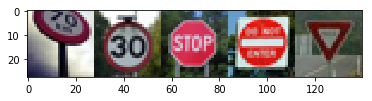

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

sign_names = np.genfromtxt('./signnames.csv', dtype='i4,|S100', delimiter=',', skip_header=True)

test_image_dir = './images/test/'
def read_test_images(test_image_dir, max_test_files=5):
    images = np.array([], dtype=np.uint8).reshape([0] + image_crop_size)
    i = 0
    for f in sorted(os.listdir(test_image_dir))[:max_test_files]:
        cur_img = im.open(os.path.join(test_image_dir, f))
        cur_img = np.reshape(cur_img.resize((image_crop_size[1], image_crop_size[0]), im.BICUBIC), [1] + image_crop_size)
        images = np.vstack((images, cur_img))
        if i >= max_test_files:
            break
    return images

# Read test images.
test_images = read_test_images(test_image_dir)

# Display the images.
plt.imshow(np.hstack(test_images))


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

probs     = probs_layer(logits)
res_probs = sess.run(probs, feed_dict={image_input: test_images, keep_prob: 1.})
for i in range(res_probs.shape[0]):
    top_1_idx = np.argmax(res_probs[i])
    print('Image {}: {:.3f} ({:})'.format(i, res_probs[i][top_1_idx], sign_names[top_1_idx][1]))


Image 0: 1.000 (b'General caution')
Image 1: 1.000 (b'Speed limit (30km/h)')
Image 2: 1.000 (b'Stop')
Image 3: 1.000 (b'No entry')
Image 4: 0.627 (b'Yield')


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The model was able to correctly predict 4 out of 5 test images (so 80% accurate on those 5 images). The first image was incorrectly classified as 'General caution' while it is really a 'Speed limit (70km/h)'. Most like the reasons are:
1. Original image is cropped at the top so it does not look round anymore.
2. Image distortion which made this sign look similar to exclamation mark in 'General caution' sign.

In [16]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

top_5_preds = sess.run(tf.nn.top_k(probs, k=5), feed_dict={image_input: test_images, keep_prob: 1.})
preds   = top_5_preds[0]
indices = top_5_preds[1]
for i in range(preds.shape[0]):
    print('Image %d:' % i)
    for j in range(preds[i].shape[0]):
        print('  {:.6f} {:2} ({})'.format(preds[i][j], indices[i][j], sign_names[indices[i][j]][1]))


Image 0:
  1.000000 18 (b'General caution')
  0.000000 26 (b'Traffic signals')
  0.000000 17 (b'No entry')
  0.000000 12 (b'Priority road')
  0.000000 13 (b'Yield')
Image 1:
  0.999987  1 (b'Speed limit (30km/h)')
  0.000013  2 (b'Speed limit (50km/h)')
  0.000000  0 (b'Speed limit (20km/h)')
  0.000000  5 (b'Speed limit (80km/h)')
  0.000000  6 (b'End of speed limit (80km/h)')
Image 2:
  1.000000 14 (b'Stop')
  0.000000 17 (b'No entry')
  0.000000 11 (b'Right-of-way at the next intersection')
  0.000000 21 (b'Double curve')
  0.000000 13 (b'Yield')
Image 3:
  1.000000 17 (b'No entry')
  0.000000 14 (b'Stop')
  0.000000 26 (b'Traffic signals')
  0.000000 12 (b'Priority road')
  0.000000  9 (b'No passing')
Image 4:
  0.627176 13 (b'Yield')
  0.116796 14 (b'Stop')
  0.065882 17 (b'No entry')
  0.026682  0 (b'Speed limit (20km/h)')
  0.024906 12 (b'Priority road')


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
Looking at top 5 probabilities, the model makes correct top-1 prediction for 4 signs. For the sign with incorrect top-1 prediction, the model does not have correct prediction even in top 5 predictions. The model is very certain in its incorrect prediction (basically outputting close to 100% probability.
There is an interesting case with the last sign (Yield). Even though the model produced correct top-1 output, the corresponding probability is only 62.7% which is in contrast to other predictions where the model produced close to 100% (both for correct and incorrect predictions).

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.